In [1]:
import pandas as pd
import datetime
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("./Datasets/109A2/109A2.csv", sep=',', header=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335396 entries, 0 to 335395
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   發生時間    335396 non-null  object 
 1   發生地點    335396 non-null  object 
 2   死亡受傷人數  335396 non-null  object 
 3   車種      335396 non-null  object 
 4   經度      335396 non-null  float64
 5   緯度      335396 non-null  float64
dtypes: float64(2), object(4)
memory usage: 15.4+ MB


In [4]:
df.isna().sum()

發生時間      0
發生地點      0
死亡受傷人數    0
車種        0
經度        0
緯度        0
dtype: int64

In [5]:
#做資料的整理
df = pd.read_csv("./Datasets/109A2/109A2.csv", sep=',', header=0)
df.loc[:, '發生時間'] = df['發生時間'].str.replace('年','-')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('月','-')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('日','')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('時',':')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('分',':')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('秒','')
df.loc[:, '發生時間'] = df['發生時間'].str.replace('109','2020')

df.insert(0,'日期',df.loc[:,'發生時間'].str.replace('\s\d+\:\d+\:\d+','', regex=True))
df.loc[:, '發生時間'] = df['發生時間'].str.replace('\d+\-\d+\-\d+\s','', regex=True)

df.insert(3,'死數',df.loc[:,'死亡受傷人數'].str.replace('\;受傷\d','', regex=True))
df.loc[:, '死亡受傷人數'] = df['死亡受傷人數'].str.replace('死亡\d\;','', regex=True)

df.loc[:, '死數'] = df['死數'].str.replace('死亡','').astype('int32')
df.loc[:, '死亡受傷人數'] = df['死亡受傷人數'].str.replace('受傷','').astype('int32')

df = df.rename({"發生時間": "時間", "發生地點": "地點", "死亡受傷人數": "傷數"}, axis='columns')
df.set_index('日期', inplace=True)
df

,時間,地點,死數,傷數,車種,經度,緯度
日期,,,,,,,
2020-01-01,00:00:56,桃園市中壢區高鐵南路與公園路路口,0,2,自用-小客車;普通重型-機車;乘客-人,121.207980,25.005826
2020-01-01,00:01:00,高雄市大樹區大坑路108之18號前0.0公尺,0,3,普通重型-機車;乘客-人;乘客-人,120.439800,22.710880
2020-01-01,00:04:25,新竹市東區經國路口 / 新竹市東區水田街口,0,1,自用-小客車;普通重型-機車,120.965928,24.812959
2020-01-01,00:05:00,臺南市南區明興路1034號,0,1,普通重型-機車;自用-小客車,120.183415,22.930683
2020-01-01,00:06:00,桃園市平鎮區環南路2段口 / 桃園市平鎮區新富五街口,0,1,自用-小客車;自用-小客車,121.214405,24.940303
...,...,...,...,...,...,...,...
2020-12-30,10:33:00,新北市三重區新北市三重區重陽路與大智街,0,1,行人-人;自用-小客車,121.486875,25.059188
2020-12-30,11:20:00,新北市三重區新北市三重區中正南路與重安街,0,1,普通重型-機車;人力車-慢車,121.492743,25.052300
2020-12-30,13:11:00,新北市板橋區新北市板橋區大同街35巷與文聖街,0,1,自用-小客車;普通重型-機車,121.476771,25.028017


In [6]:
cb = [3252789,1762194,2078361,2872294,2029219,2957466,436501,540347,548460,1327131,527778,715045,533264,917199,236560,328480,115794,284216,433284,274994,114647,10977]
cc = ['新北市','臺北市','桃園市','臺中市','臺南市','高雄市','宜蘭縣','新竹縣','苗栗縣','彰化縣','南投縣','雲林縣','嘉義縣','屏東縣','臺東縣','花蓮縣','澎湖縣','基隆市','新竹市','嘉義市','金門縣','連江縣']
car_hold = pd.DataFrame(cb, index=cc, columns=['持車量'])

index2 = sorted(list(set(df['地點'].str[:3])))
df2_die = []
df2_hurt = []
for i in index2:
    df2_die.append(df.loc[df['地點'].str.startswith(i), '死數'].sum())
    df2_hurt.append(df.loc[df['地點'].str.startswith(i), '傷數'].sum())
df2 = pd.DataFrame(df2_die, index = index2, columns=['死數'])
df2.loc[:, '傷數'] = df2_hurt
df2.loc[:, '傷數'] = df2_hurt
df2 = pd.merge(df2, car_hold, left_index=True, right_index=True)
df2.loc[:, '傷亡率'] = round(((df2['死數'] + df2['傷數']) / df2['持車量'])*100, 1).astype('str')+'%'
df2.sort_values("傷亡率",inplace=False)

,死數,傷數,持車量,傷亡率
連江縣,0,54,10977,0.5%
金門縣,0,1126,114647,1.0%
嘉義市,0,3558,274994,1.3%
澎湖縣,0,1461,115794,1.3%
苗栗縣,0,8261,548460,1.5%
新北市,0,56310,3252789,1.7%
高雄市,0,52614,2957466,1.8%
嘉義縣,0,9701,533264,1.8%
臺中市,3,51210,2872294,1.8%
雲林縣,0,12658,715045,1.8%


In [7]:
cont_col=['死數','傷數','持車量']

In [8]:
# 對連續變數做預處理
scaler = StandardScaler()
pg_cont = scaler.fit_transform(df2[cont_col])
pg_cont_df = pd.DataFrame(pg_cont, columns=cont_col)

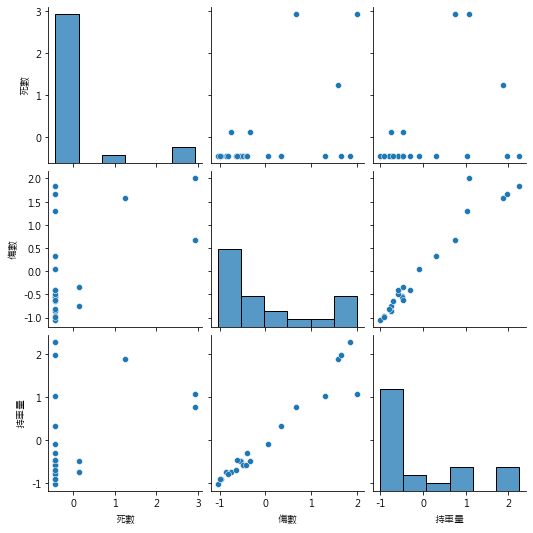

In [9]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.pairplot(pg_cont_df)

In [10]:
kmean = KMeans(n_clusters=7, random_state=0)

In [11]:
label_kmeans = kmean.fit_predict(pg_cont_df)

In [12]:
for i in range(min(set(label_kmeans)),max(set(label_kmeans))+1):
    print("label_kmeans為",i,"的比數有:", len(label_kmeans[label_kmeans == i]))

label_kmeans為 0 的比數有: 8
label_kmeans為 1 的比數有: 3
label_kmeans為 2 的比數有: 1
label_kmeans為 3 的比數有: 1
label_kmeans為 4 的比數有: 1
label_kmeans為 5 的比數有: 2
label_kmeans為 6 的比數有: 6


In [13]:
pg_cont_df_2 = pg_cont_df.copy()
pg_cont_df_2["k_target"] = label_kmeans

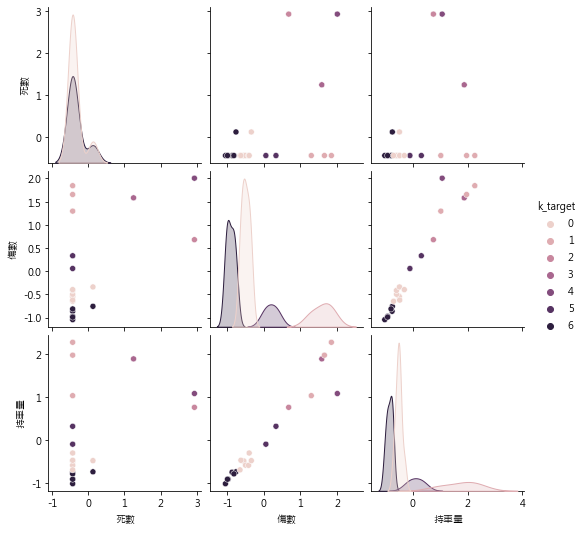

In [14]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.pairplot(pg_cont_df_2, hue="k_target")
plt.show()

In [15]:
range_n_clusters = [2,3,4,5,6,7]

In [16]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=2022)
    cluster_labels = clusterer.fit_predict(pg_cont_df)

    silhouette_avg = silhouette_score(pg_cont_df, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.6833808388099318
For n_clusters = 3 The average silhouette_score is : 0.7181727442987749
For n_clusters = 4 The average silhouette_score is : 0.536281430546219
For n_clusters = 5 The average silhouette_score is : 0.514384458389929
For n_clusters = 6 The average silhouette_score is : 0.4338149108196385
For n_clusters = 7 The average silhouette_score is : 0.38442834006438636


,死數,傷數
Jan,3,41905
Feb,0,35676
Mar,3,37927
Apr,0,36327
May,0,38780
Jun,5,40828
Jul,3,41139
Aug,0,39057
Sep,0,38026
Oct,1,41189


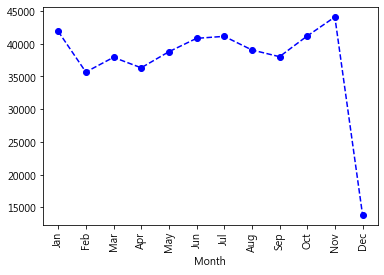

In [17]:
df3_die = []
df3_hurt = []
index3 = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
zero = lambda x:i if len(str(i))==2 else '0' + str(i) 
for i in range(1,13):
    df3_die.append(df.loc[df.index.str.startswith('2020-'+ str(zero(i))), '死數'].sum())
    df3_hurt.append(df.loc[df.index.str.startswith('2020-'+ str(zero(i))), '傷數'].sum())
df3= pd.DataFrame(df3_die, index = index3, columns=['死數'])
df3.loc[:, '傷數'] = df3_hurt
df3

a = plt.plot(df3.index, df3.傷數, 'bo--')
a = plt.xlabel('Month') # 設定x軸標題
a = plt.xticks(df3.index, rotation='vertical') # 設定x軸label以及垂直顯示
plt.show()

In [18]:
#休息日計算
national_holiday = ['0123','0124','0125','0126','0127','0128','0129','0228','0229','0301','0402','0403','0404','0405','0501','0502','0503','0625','0626','0627','0628','1001','1002','1003','1004','1009','1010','1011']
make_up = ['0215','0620','0926']

start = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
holiday_day = []
yearday_count = 0
while start <= datetime.datetime.strptime('2020-12-31', '%Y-%m-%d'):
    if start.date().weekday() == 5 or start.date().weekday() ==6:
        holiday_day.append(str(start.date()))
    start += datetime.timedelta(days=1)
    yearday_count += 1
#print(holiday_day)
holiday_caraccident = 0
for i in holiday_day:
    holiday_caraccident += df.loc[df.index.str.startswith(i), '傷數'].sum()
    holiday_caraccident += df.loc[df.index.str.startswith(i), '死數'].sum()
totle_caraccident = df.loc[:, '傷數'].sum() +df.loc[:, '死數'].sum()
work_caraccident = totle_caraccident - holiday_caraccident

df4 = pd.DataFrame({'傷亡數':[holiday_caraccident,work_caraccident,totle_caraccident],
                    '天數':[len(holiday_day),yearday_count-len(holiday_day),yearday_count],
                    '日均傷亡':[round(holiday_caraccident/len(holiday_day)),
                            round(work_caraccident/(yearday_count-len(holiday_day))),
                            round(totle_caraccident/yearday_count)]}
                ,index=['假日','平日','全年'])
df4

,傷亡數,天數,日均傷亡
假日,112965,104,1086
平日,335864,262,1282
全年,448829,366,1226


In [19]:
a = ['00:','01:','02:','03:','04:','05:','06:','07:','08:','09:','10:','11:','12:','13:','14:','15:','16:','17:','18:','19:','20:','21:','22:','23:']
time_period = []
for i in range(0,len(a),2):
    b = df.loc[df['時間'].str.startswith(a[i]), '傷數'].sum() + df.loc[df['時間'].str.startswith(a[i]), '死數'].sum()
    c = df.loc[df['時間'].str.startswith(a[i+1]), '傷數'].sum() + df.loc[df['時間'].str.startswith(a[i+1]), '死數'].sum()
    time_period.append(b + c)

a = ['00:','01:','02:','03:','04:','05:','06:','07:','08:','09:','10:','11:','12:','13:','14:','15:','16:','17:','18:','19:','20:','21:','22:','23:']
cc = ['新北市','臺北市','桃園市','臺中市','臺南市','高雄市','宜蘭縣','新竹縣','苗栗縣','彰化縣','南投縣','雲林縣','嘉義縣','屏東縣','臺東縣','花蓮縣','澎湖縣','基隆市','新竹市','嘉義市','金門縣','連江縣']
dict = {}
def query_mydata(df,i,j):
    return df['時間'].str.startswith(j) & df['地點'].str.startswith(i)
for i in cc:
    time_period2 = []
    for j in range(0,len(a),2):
        b = df.loc[query_mydata(df,i,a[j]), '傷數'].sum() + df.loc[query_mydata(df,i,a[j]), '死數'].sum()
        c = df.loc[query_mydata(df,i,a[j+1]), '傷數'].sum() + df.loc[query_mydata(df,i,a[j+1]), '死數'].sum()
        time_period2.append(b + c)
    dict[i] = time_period2
dict["總傷亡數"] = time_period
df5 = pd.DataFrame(dict, index=[['0-2時','2-4時','4-6時','6-8時','8-10時','10-12時','12-14時','14-16時','16-18時','18-20時','20-22時','22-0時']])
pd.set_option('display.max_colwidth',30)
df5

,新北市,臺北市,桃園市,臺中市,臺南市,高雄市,宜蘭縣,新竹縣,苗栗縣,彰化縣,...,屏東縣,臺東縣,花蓮縣,澎湖縣,基隆市,新竹市,嘉義市,金門縣,連江縣,總傷亡數
0-2時,1311,845,1027,797,771,866,145,155,113,324,...,325,64,84,29,121,205,62,20,0,7728
2-4時,578,304,448,322,322,364,77,85,66,144,...,171,36,45,19,62,92,46,4,1,3432
4-6時,731,409,724,509,498,564,152,142,103,352,...,249,72,98,19,102,97,48,9,1,5327
6-8時,5274,2317,7122,5436,5224,5675,1122,1709,1027,3404,...,2113,395,711,124,533,1191,355,106,4,47520
8-10時,7960,5267,8211,6679,5919,7047,1451,2193,1019,3561,...,2691,551,995,145,674,1943,444,126,6,60998
10-12時,6026,3752,6307,5827,5386,6415,1396,1501,1027,3222,...,2913,638,1025,201,665,1380,488,129,2,52525
12-14時,5963,3670,5975,5471,4816,5589,1284,1285,824,2839,...,2336,583,1023,187,605,1417,536,161,4,48187
14-16時,5630,3565,5791,5350,4868,5790,1202,1355,833,2864,...,2336,578,899,184,522,1162,401,142,12,47124
16-18時,7433,4343,8800,8172,7276,8165,1789,2154,1394,4578,...,3544,737,1267,251,849,1722,515,189,21,68517
18-20時,6917,4153,7338,6285,5385,6177,1112,1756,1024,3049,...,2535,488,875,174,686,1623,317,151,1,53608


In [20]:
mount_map = folium.Map([23.6, 120.9], zoom_start=7.7, tiles='CartoDB positron', width=500)

for i in range(5000):#len(df['緯度'].values)): 
    a = folium.Circle(location=[df['緯度'][i],df['經度'][i]]).add_to(mount_map)
mount_map